# 2023 제1회 철도 인공지능 경진대회
- 주어진 주행데이터 및 선로데이터를 이용하여, 탈선계수에 해당하는 이하 4개 항목을 예측하는 모델을 만듭니다.
    - YL_M1_B1_W1: 좌측 전위 차륜 탈선계수
    - YR_M1_B1_W1: 우측 전위 차륜 탈선계수
    - YL_M1_B1_W2: 좌측 후위 차륜 탈선계수
    - YR_M1_B1_W2: 우측 후위 차륜 탈선계수

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
data_s100 = pd.read_csv('./data/data_s100.csv')
data_c100 = pd.read_csv('./data/data_c100.csv')
answer_sample = pd.read_csv('./data/answer_sample.csv')
data_columns = pd.read_csv('./data/data_columns.csv')
data_columns

### 그래프

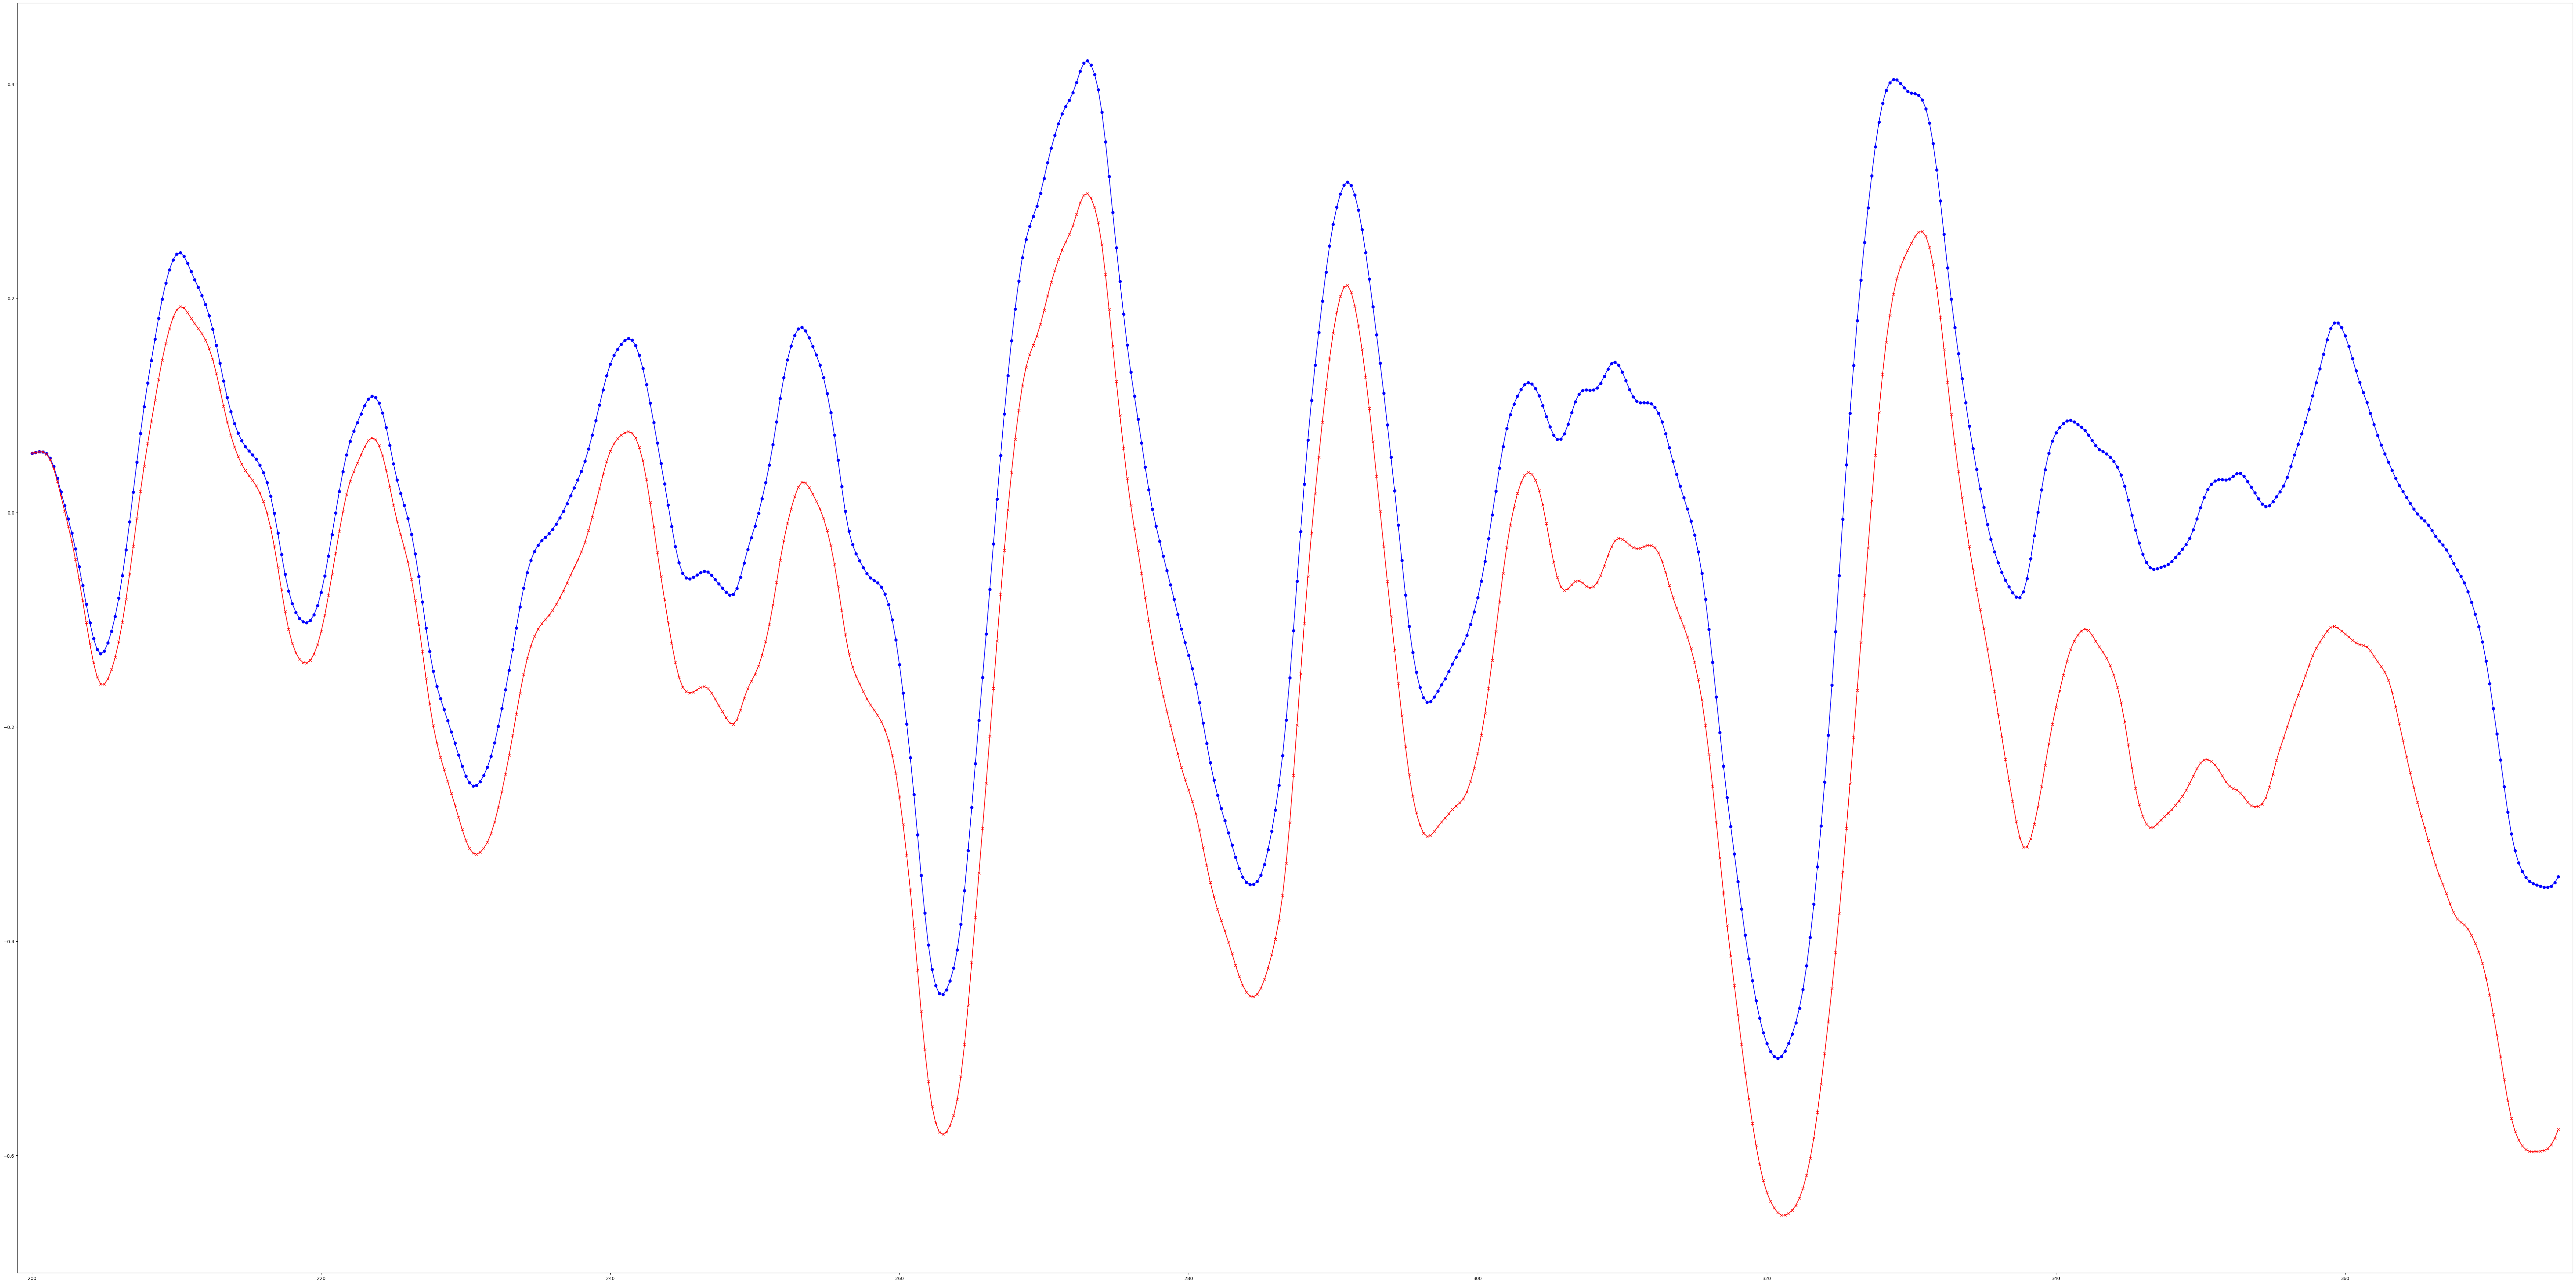

In [21]:
x = data_s100.iloc[800:1500,0]
y1 = data_s100.iloc[800:1500,1:2]
y2 = data_c100.iloc[800:1500,1:2]

# plt.plot(x, y1, marker='o', linestyle='-', color='b', label='데이터1')
# plt.plot(x, y2, marker='s', linestyle='-', color='r', label='데이터2')

plt.figure(figsize=(100, 50))
plt.plot(x,y1, marker='o', linestyle = '-', color = 'b', label = 's_data')
plt.plot(x,y2, marker='x', linestyle = '-', color = 'r', label = 'c_data')
plt.xlim(min(x) - 1, max(x) + 1)
plt.show()

In [2]:
dic = {'a':[1,2],'b':[1,2],'c':[1,2]}

for i, b in dic.items():
    print(i, b)

a [1, 2]
b [1, 2]
c [1, 2]


In [8]:
import numpy as np

# 가상의 10000행 35열 데이터 생성 (임의의 데이터)
data = np.random.rand(10, 35)

print(len(data), data.shape)
# 시퀀스 길이와 피처 개수 설정
sequence_length = 2
feature_count = 35

# 3D 데이터 생성
X_3d = []
y = []
for i in range(len(data) - sequence_length):
    sequence = data[i:i + sequence_length]
    print(sequence)
    X_3d.append(sequence)
    # 마지막 행을 사용하여 10000행 4열의 데이터를 추출 (예시)
    target = sequence[-1, -4:]  # 마지막 행의 마지막 4열을 추출
    y.append(target)

X_3d = np.array(X_3d)
y = np.array(y)

print("3D 데이터 형태:", X_3d.shape)  # (9990, 10, 35)
print("타겟 데이터 형태:", y.shape)  # (9990, 4)

10 (10, 35)
[[0.80347985 0.14229585 0.97640204 0.92258964 0.88796355 0.71832772
  0.36162577 0.65945914 0.26978442 0.97079059 0.5908793  0.98242373
  0.10987392 0.7022174  0.78219249 0.1171659  0.71431974 0.30209082
  0.17236999 0.59793154 0.50225719 0.94632503 0.69646266 0.44541239
  0.76666833 0.66450763 0.89728685 0.14240385 0.89588514 0.23537487
  0.15155316 0.170701   0.53630067 0.36521187 0.79396281]
 [0.61618799 0.82761247 0.84878444 0.93125684 0.42446093 0.66867228
  0.27205258 0.98663765 0.2463469  0.10238899 0.69140273 0.35746428
  0.89955975 0.24814488 0.08858612 0.87953722 0.82039358 0.88160157
  0.13603147 0.77049885 0.96540528 0.22191969 0.97571429 0.61576736
  0.60493732 0.40132449 0.99857173 0.63884363 0.939242   0.68171229
  0.24946427 0.08424333 0.7115364  0.07443575 0.92491075]]
[[0.61618799 0.82761247 0.84878444 0.93125684 0.42446093 0.66867228
  0.27205258 0.98663765 0.2463469  0.10238899 0.69140273 0.35746428
  0.89955975 0.24814488 0.08858612 0.87953722 0.8203935

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# 데이터와 라벨 생성 (임의의 가상 데이터)
input_data = torch.randn(991, 36, 100)
output_labels = torch.randn(991, 4)

# 모델 클래스 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 모델 및 하이퍼파라미터 설정
input_size = 100  # 입력 피처 개수
hidden_size = 64  # LSTM 은닉 상태 크기
num_layers = 2    # LSTM 레이어 개수
output_size = 4   # 출력 크기 (예측할 피처 개수)
learning_rate = 0.001
num_epochs = 10

# 데이터 로더 생성
batch_size = 64
data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(input_data, output_labels), batch_size=batch_size, shuffle=True)

# 모델 인스턴스 생성
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

print("학습 완료")

Epoch [1/10], Loss: 16.6055
Epoch [2/10], Loss: 16.5293
Epoch [3/10], Loss: 16.2114
Epoch [4/10], Loss: 15.7677
Epoch [5/10], Loss: 14.8559
Epoch [6/10], Loss: 13.4882
Epoch [7/10], Loss: 11.5936
Epoch [8/10], Loss: 9.5116
Epoch [9/10], Loss: 7.4050
Epoch [10/10], Loss: 5.6190
학습 완료


In [10]:
import torch

# 가상의 데이터 생성 (임의의 데이터)
data = torch.randn(10000, 36)  # (row, column)

# 시퀀스 길이와 입력 피처 개수 설정
sequence_length = 10
input_size = data.shape[1]

# unfold 함수를 사용하여 데이터를 변환
sequences = data.unfold(0, sequence_length, 1)  # (batch_size, sequence_length, input_size)
print("변환된 시퀀스 데이터의 형태:", sequences.shape)

변환된 시퀀스 데이터의 형태: torch.Size([9991, 36, 10])
